In [47]:
import polars as pl
from datetime import datetime
from typing import Tuple, List
import warnings
import sys
import numpy as np
import scipy
import statsmodels.api as sm

POS_RET_PCT_SCALE_THRESHOLD = 0.01

input_path = "data/all_data_1d.parquet"
output_path = "data/alpha1_pred.parquet"
is_prod = False

In [48]:
FACTOR_COMBINATION_LIST = [
    "amihud",
    "return_skewness",
    "alpha30",
    "alpha36",
    "alpha40",
    "alpha45",
    "ID",
]

UPDATE_POSITION_TIME = 10

import polars as pl
input_data = pl.read_parquet(input_path)
input_data = input_data.with_columns(pl.from_epoch(pl.col("open_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("open_time"))
input_data = input_data.with_columns(pl.from_epoch(pl.col("close_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("close_time"))
input_data = input_data.sort(by=["symbol", "open_time"])

# for production need
input_data = input_data.filter(
    ~pl.col("symbol").is_in(
        ["BTCUSDT", "ETHUSDT", "BCHUSDT", "LTCUSDT", "ETCUSDT", "LINKUSDT", "AVAXUSDT", "SOLUSDT"]
    )
).filter(pl.col("symbol").str.ends_with("USDT"))

input_data = input_data.with_columns(pl.from_epoch("open_time", time_unit="ms").alias("open_datetime"))

from factor.pipeline_factor import AddPastReturnFactor
input_data = AddPastReturnFactor(input_data, day_num=10)


from factor.pipeline_factor import AddAmihud
input_data = AddAmihud(input_data)

from factor.pipeline_factor import AddReturnSkewness
input_data = AddReturnSkewness(input_data, 7)

from factor.pipeline_factor import AddID
input_data = AddID(input_data)  # 1.895

from production.alpha101_prod import CalcAlpha101Factor
# Calculate alpha101 factor
alpha101_factor_list = [x for x in FACTOR_COMBINATION_LIST if "alpha" in x]
input_data = CalcAlpha101Factor(input_data, calc_factor_list=alpha101_factor_list)

input_data

alpha30
alpha36
alpha40
alpha45


symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,open_datetime,past_1day_close_return,past_2day_close_return,past_3day_close_return,past_4day_close_return,past_5day_close_return,past_6day_close_return,past_7day_close_return,past_8day_close_return,past_9day_close_return,past_10day_close_return,return,amihud,return_skewness,ID,alpha30,alpha36,alpha40,alpha45
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1000000MOGUSDT""",2024-11-07 00:00:00,2.0896,2.25,1.9158,2.1226,3.0109764e7,2024-11-07 23:59:59.999,6.2969e7,311739,1.4979e7,3.1363e7,2024-11-07 00:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-08 00:00:00,2.1229,2.1962,1.9278,2.0126,2.2044e7,2024-11-08 23:59:59.999,4.5478e7,300480,1.0508e7,2.1705e7,2024-11-08 00:00:00,-5.182324,null,null,null,null,null,null,null,null,null,-5.182324,null,null,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-09 00:00:00,2.0126,2.1032,1.91,2.0543,1.4402e7,2024-11-09 23:59:59.999,2.8930e7,251456,6998440.5,1.4066e7,2024-11-09 00:00:00,2.071947,-3.217752,null,null,null,null,null,null,null,null,2.071947,null,null,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-10 00:00:00,2.0542,2.2498,1.9333,2.0192,2.6371799e7,2024-11-10 23:59:59.999,5.4620e7,430257,1.2479e7,2.5866e7,2024-11-10 00:00:00,-1.708611,0.327934,-4.871384,null,null,null,null,null,null,null,-1.708611,null,null,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-11 00:00:00,2.0197,2.1457,1.85,1.926,2.2621e7,2024-11-11 23:59:59.999,4.4398e7,346642,1.1143e7,2.1888e7,2024-11-11 00:00:00,-4.615689,-6.245436,-4.302892,-9.262226,null,null,null,null,null,null,-4.615689,null,null,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-12 00:00:00,1.9253,1.9863,1.671,1.8225,2.2843e7,2024-11-12 23:59:59.999,4.1843e7,290100,1.0833e7,1.9854e7,2024-11-12 00:00:00,-5.373832,-9.741482,-11.283649,-9.445493,-14.138321,null,null,null,null,null,-5.373832,null,null,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-13 00:00:00,1.8208,2.452,1.6275,2.4126,4.2202e7,2024-11-13 23:59:59.999,8.5632e7,495010,2.0292e7,4.1186e7,2024-11-13 00:00:00,32.378601,25.264798,19.482964,17.441464,19.874789,13.662489,null,null,null,null,32.378601,null,1.647259,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-14 00:00:00,2.4134,2.6309,2.2051,2.3482,4.1400e7,2024-11-14 23:59:59.999,9.9772e7,689091,2.0345e7,4.9033e7,2024-11-14 00:00:00,-2.669319,28.844993,21.92108,16.293582,14.306576,16.674948,10.628475,null,null,null,-2.669319,null,1.893301,null,0.0,0.0,0.0,0.0
"""1000000MOGUSDT""",2024-11-15 00:00:00,2.3483,2.8527,2.2309,2.7967,3.1853e7,2024-11-15 23:59:59.999,8.0035e7,539371,1.5454e7,3.8832e7,2024-11-15 00:00:00,19.099736,15.920584,53.454047,45.207684,38.505349,36.138831,38.959555,31.758221,null,null,19.099736,null,1.083751,null,0.0,0.0,0.0,0.0


In [49]:
# 截面归一化
from factor.pipeline_factor import normalize_factors
input_data = normalize_factors (input_data=input_data, factor_combination_list=FACTOR_COMBINATION_LIST)


normalizing column: amihud
normalizing column: return_skewness
normalizing column: alpha30
normalizing column: alpha36
normalizing column: alpha40
normalizing column: alpha45
normalizing column: ID


In [50]:
# below for combine factors
from factor.pipeline_factor import AddFutureRetCol
print(f"begin to calc linear compound factor: {FACTOR_COMBINATION_LIST}")
input_data = AddFutureRetCol(input_data, UPDATE_POSITION_TIME)
input_data

from factor.pipeline_factor import CalcLinearCompoundFactor
input_data = CalcLinearCompoundFactor(
    input_data, UPDATE_POSITION_TIME, FACTOR_COMBINATION_LIST
)

from factor.pipeline_factor import AddTotalPosValueScale
input_data, day_scale_df = AddTotalPosValueScale(
    input_data, day_num=10, trade_long_rank=20, trade_short_rank=10
)

if is_prod:
    # for normal run, save all data
    results = input_data
else:
    # for backtest and research, remove the last few rows and symbols whose min value is larger then 5 USDT
    # results = input_data.filter(pl.col("close_price_fut_7day_ret").is_not_null())
    results = input_data
results.write_parquet(output_path)
results

begin to calc linear compound factor: ['amihud', 'return_skewness', 'alpha30', 'alpha36', 'alpha40', 'alpha45', 'ID']
fit linear model, date_threshold: 2023-01-01 00:00:00


symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,open_datetime,past_1day_close_return,past_2day_close_return,past_3day_close_return,past_4day_close_return,past_5day_close_return,past_6day_close_return,past_7day_close_return,past_8day_close_return,past_9day_close_return,past_10day_close_return,return,amihud,return_skewness,ID,alpha30,alpha36,alpha40,alpha45,open_price_fut_1day_ret,close_price_fut_1day_ret,open_price_fut_2day_ret,close_price_fut_2day_ret,open_price_fut_3day_ret,close_price_fut_3day_ret,…,close_price_fut_7day_ret,open_price_fut_8day_ret,close_price_fut_8day_ret,open_price_fut_9day_ret,close_price_fut_9day_ret,open_price_fut_10day_ret,close_price_fut_10day_ret,linear_compound_factor_1day,linear_compound_factor_2day,linear_compound_factor_3day,linear_compound_factor_4day,linear_compound_factor_5day,linear_compound_factor_6day,linear_compound_factor_7day,linear_compound_factor_8day,linear_compound_factor_9day,linear_compound_factor_10day,long_value_scale_1day,short_value_scale_1day,long_value_scale_2day,short_value_scale_2day,long_value_scale_3day,short_value_scale_3day,long_value_scale_4day,short_value_scale_4day,long_value_scale_5day,short_value_scale_5day,long_value_scale_6day,short_value_scale_6day,long_value_scale_7day,short_value_scale_7day,long_value_scale_8day,short_value_scale_8day,long_value_scale_9day,short_value_scale_9day,long_value_scale_10day,short_value_scale_10day
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1000000MOGUSDT""",2024-11-07 00:00:00,2.0896,2.25,1.9158,2.1226,3.0109764e7,2024-11-07 23:59:59.999,6.2969e7,311739,1.4979e7,3.1363e7,2024-11-07 00:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-1.432804,-1.774045,0.650705,-0.090856,1.593606,-5.182324,-3.684916,-3.217752,-1.694104,-4.871384,…,10.628475,12.38036,31.758221,33.858155,25.073024,27.024311,16.24894,null,null,null,null,null,null,null,null,null,null,1.0,1.0,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.0,1.0,1.2,0.8
"""1000000MOGUSDT""",2024-11-08 00:00:00,2.1229,2.1962,1.9278,2.0126,2.2044e7,2024-11-08 23:59:59.999,4.5478e7,300480,1.0508e7,2.1705e7,2024-11-08 00:00:00,-5.182324,null,null,null,null,null,null,null,null,null,-5.182324,null,null,null,-1.397557,-1.712287,0.623997,0.277767,-5.195723,2.071947,-3.236139,0.327934,-4.861275,-4.302892,…,38.959555,31.758444,31.908973,25.031796,22.602604,16.246644,18.587896,null,null,null,null,null,null,null,null,null,null,1.0,1.0,1.0,1.0,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.0,1.0
"""1000000MOGUSDT""",2024-11-09 00:00:00,2.0126,2.1032,1.91,2.0543,1.4402e7,2024-11-09 23:59:59.999,2.8930e7,251456,6998440.5,1.4066e7,2024-11-09 00:00:00,2.071947,-3.217752,null,null,null,null,null,null,null,null,2.071947,null,null,null,-1.389125,-1.68147,0.754116,0.053496,2.066978,-1.708611,0.352778,-6.245436,-4.337673,-11.283649,…,29.231368,31.88413,20.113907,22.61751,16.180694,18.617708,17.188337,null,null,null,null,null,null,null,null,null,null,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8
"""1000000MOGUSDT""",2024-11-10 00:00:00,2.0542,2.2498,1.9333,2.0192,2.6371799e7,2024-11-10 23:59:59.999,5.4620e7,430257,1.2479e7,2.5866e7,2024-11-10 00:00:00,-1.708611,0.327934,-4.871384,null,null,null,null,null,null,null,-1.708611,null,null,null,-1.362452,-1.688127,1.150908,0.455895,-1.679486,-4.615689,-6.274949,-9.741482,-11.362087,19.482964,…,22.201862,20.134359,18.200277,16.215558,19.225436,17.140493,2.525753,null,null,null,null,null,null,null,null,null,null,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8
"""1000000MOGUSDT""",2024-11-11 00:00:00,2.0197,2.1457

output_path data/alpha1_pred.parquet
main_backtest ==== read result hour path: data/alpha1_pred.parquet
Run Backtest. Logging configured. Log file: /home/dp/backup_crypto/crypto/src/backtest/log/factor_backtest_eval_1221_1903.log
 ==== Rolling 0: Analysis={'sharpe_ratio': 2.0348177904229194, 'final_return_pct(%)': 320.6848039723421, 'max_drawdown(%)': -23.5283932667133, 'volatility': 0.3936951240924246, 'average_daily_return': 0.002275774908658723}
 ==== Rolling 1: Analysis={'sharpe_ratio': 2.4709843930468094, 'final_return_pct(%)': 507.856778293194, 'max_drawdown(%)': -19.408759187378628, 'volatility': 0.4038557313914917, 'average_daily_return': 0.0028150170094939446}
 ==== Rolling 3: Analysis={'sharpe_ratio': 2.524045353048793, 'final_return_pct(%)': 438.61228274950594, 'max_drawdown(%)': -21.54521585961252, 'volatility': 0.36429381874379846, 'average_daily_return': 0.0026001482726002558}
 ==== Rolling 4: Analysis={'sharpe_ratio': 2.5194384055228523, 'final_return_pct(%)': 533.864369

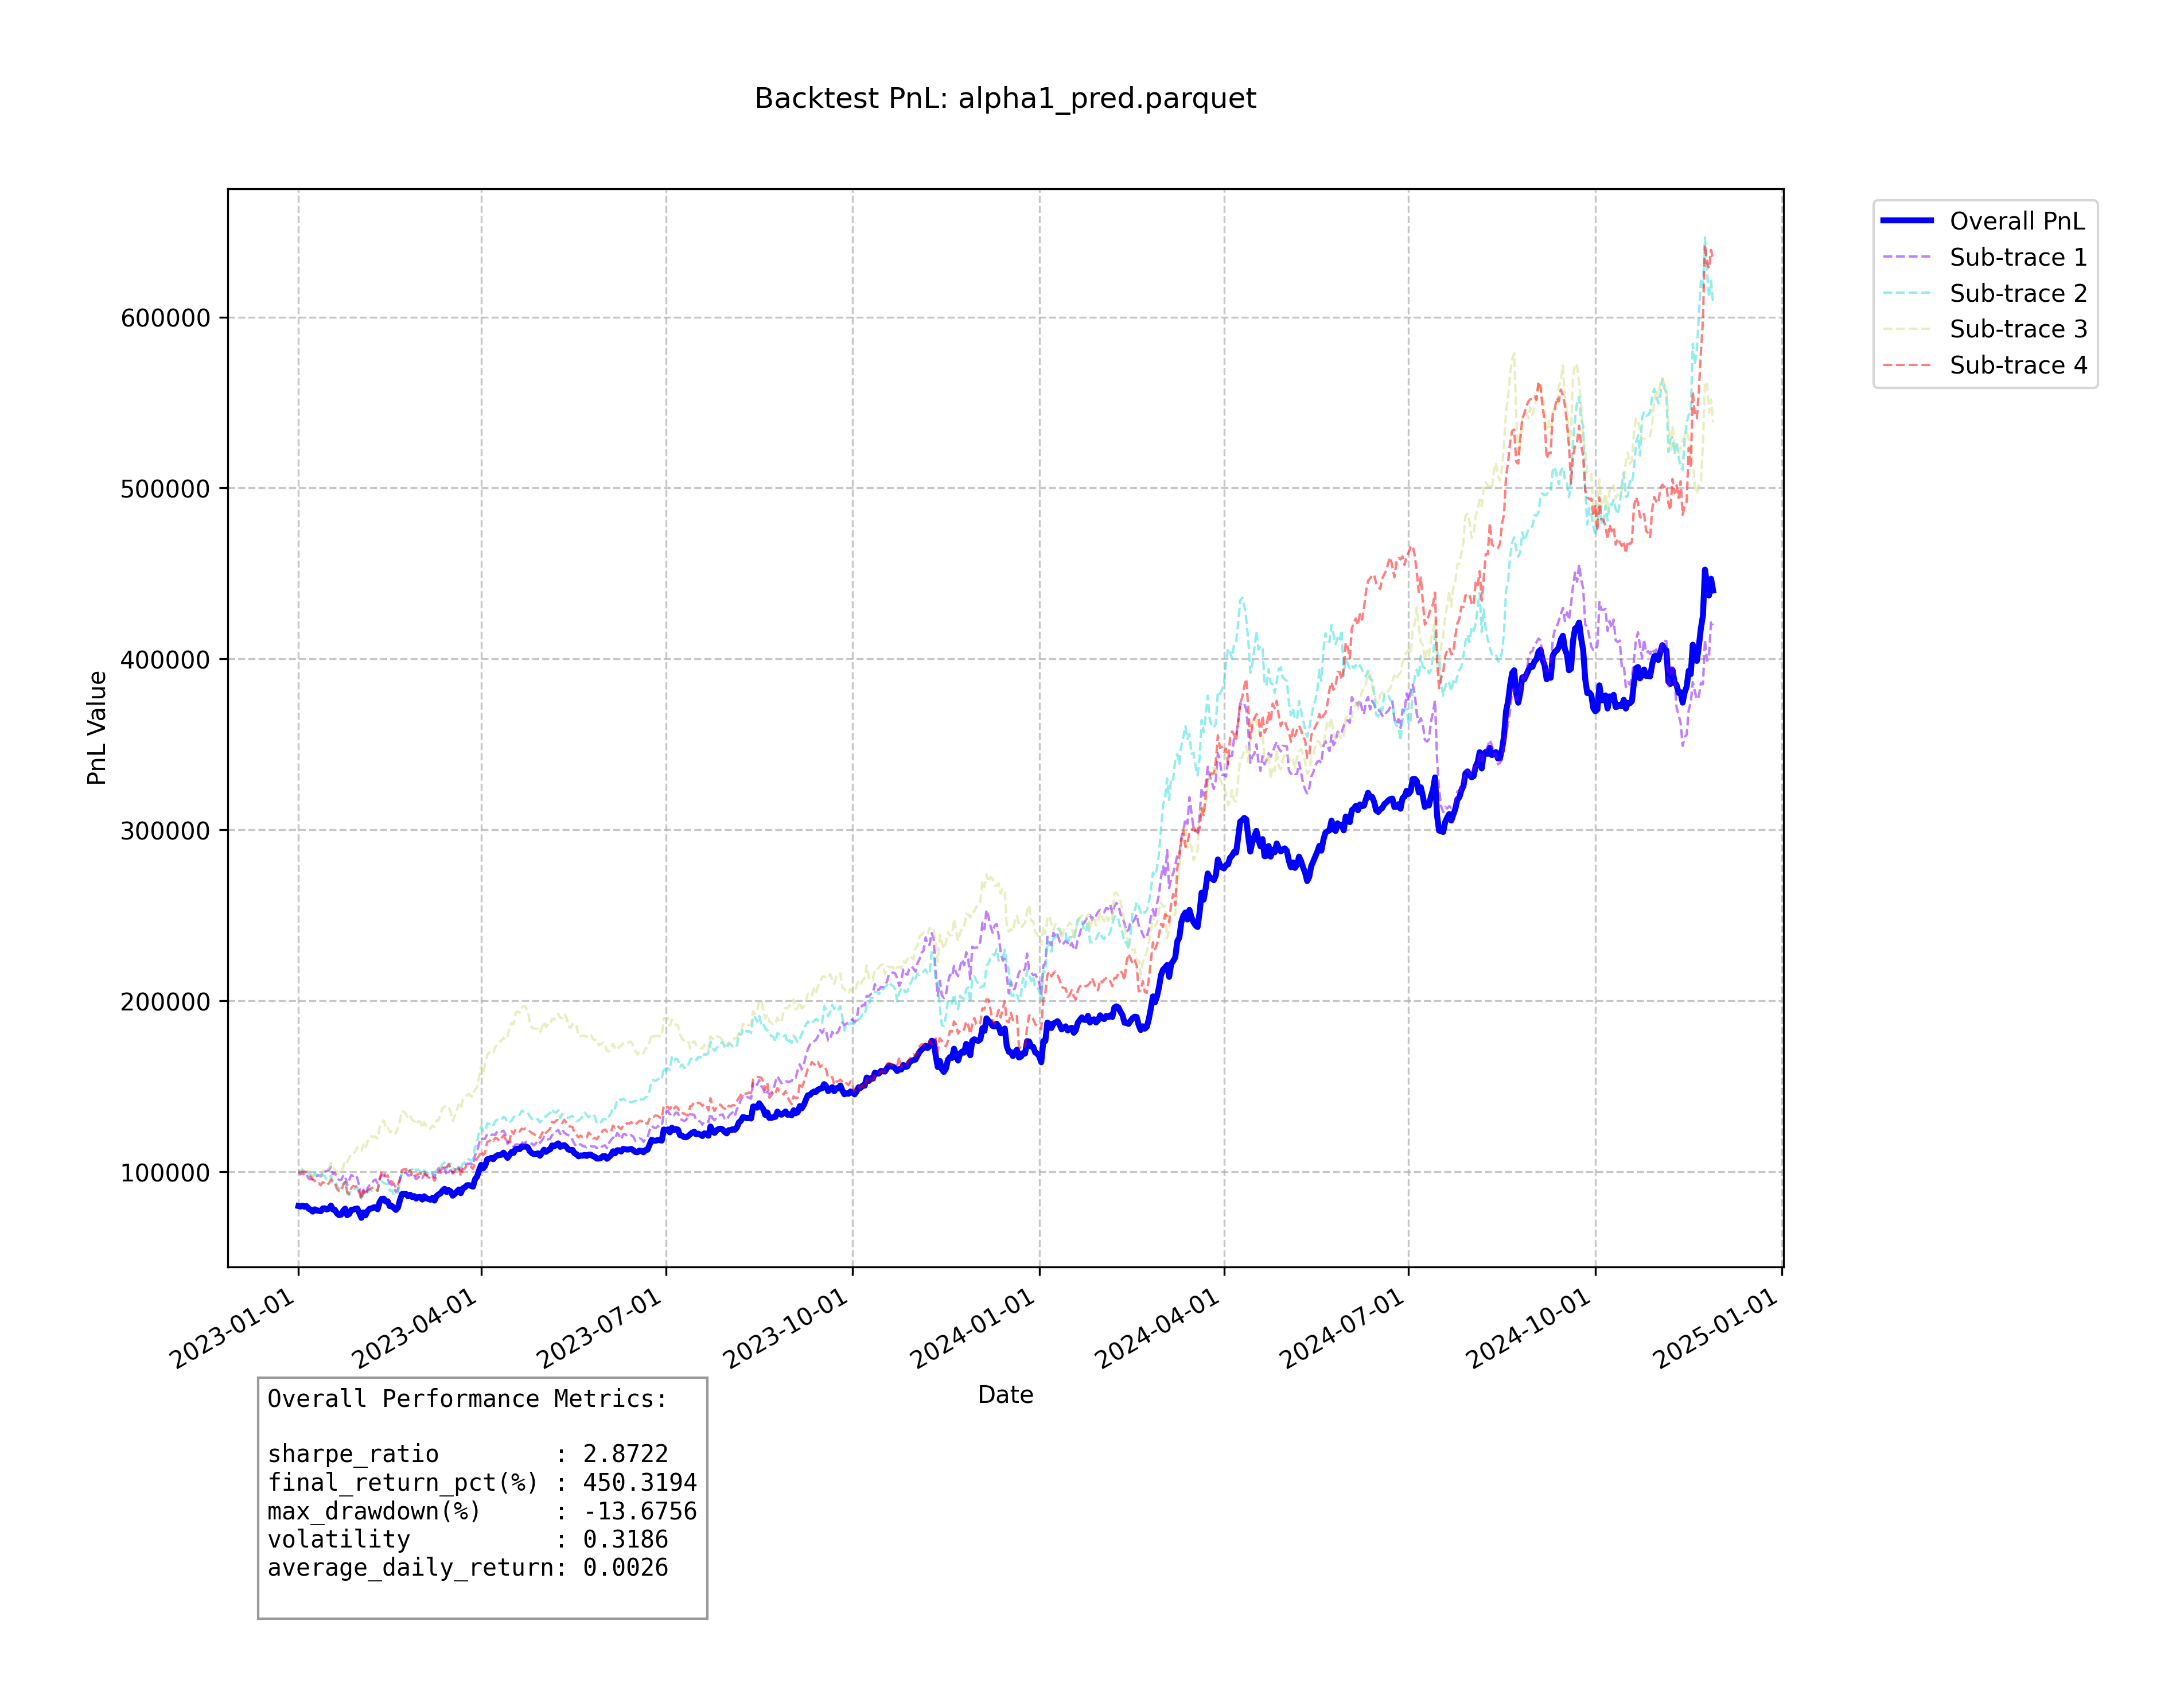

In [51]:
from backtest.backtest import main_backtest, show_plot
from backtest.config import BacktestConfig

print (f'output_path {output_path}')

day_num = 5
config = BacktestConfig(
    input_df_path = output_path,
    delist_info_path='/home/dp/backup_crypto/crypto/src/backtest/delist/delist_info.csv',
    trade_factor_name = f"linear_compound_factor_{day_num}day",
    update_position_time = day_num,
)

main_backtest(config)
show_plot(config)
